# Essay (all labs together)

To start with, let's download some scripts from a GitHub repository that implement a DBN in PyTorch.

In [8]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [9]:
%%capture
get_dbn_library()

In [10]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import torch
import torch.nn.functional as functional
import tqdm
import torchvision as tv

from DBN import DBN

Then, let's download the EMNIST dataset instead of MNIST.

In [11]:
%%capture
emnist_train = tv.datasets.EMNIST('data/','balanced', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

emnist_test = tv.datasets.EMNIST("data/", 'balanced',
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [12]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

nclasses = 47

The number shown is the number: 36
The number shown is the letter: $


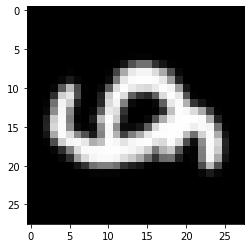

In [13]:
idx = 1 # 5 original (weird)
img = emnist_train.data[idx]
print("The number shown is the number: {}".format(emnist_train.targets[idx]) )
print("The number shown is the letter: {}".format(chr(emnist_train.targets[idx])) )
plt.imshow(img , cmap = 'gray')
plt.show()

# idx = 1 # 5 original (weird)
# img = emnist_test.data[idx]
# print("The number shown is the number: {}".format(emnist_test.targets[idx]) )
# print("The number shown is the letter: {}".format(chr(emnist_test.targets[idx])) )
# plt.imshow(img , cmap = 'gray')
# plt.show()

Let's create a training set and a test set, which we will use later:

In [14]:
emnist_data_train = emnist_train.data[10000:, :]
emnist_targets_train = emnist_train.targets[10000:]

emnist_data_test = emnist_train.data[:10000, :]
emnist_targets_test = emnist_train.targets[:10000]

## Training a DBN
Quick recall from the theory: 
- a Deep Belief Network is a stack of Restricted Boltzmann Machines, another kind of energy-based model;
- they are *unsupervised* deep learning architectures that learn a probability distribution that could have generated the training data;
- this means they can be used to run both forwards and backwards passes through the architecture, to compute either hidden representations, or "prototypical" examples of a class based on the learned probability distributions;
- they are trained using an algorithm called *contrastive divergence*, whose goal is to reduce the difference between the learned probability distribution and the true one.

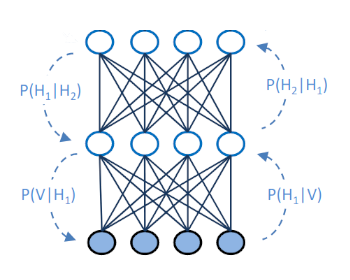

In [15]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500, 500],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=False,
                increase_to_cd_k=False,
                # use_gpu=False)
                use_gpu=True)

Let's train the network:

In [16]:
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0310   |0.0346   |323.8951 |6.1841   |
|20    |0.9744   |0.0324   |300.8839 |5.3492   |
|30    |0.9582   |0.0305   |295.3505 |4.9544   |
|40    |0.9506   |0.0298   |292.6450 |5.3946   |
|50    |0.9466   |0.0313   |291.1433 |5.4301   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0858   |0.0315   |221.3412 |3.1763   |
|20    |1.0299   |0.0299   |214.5307 |2.9967   |
|30    |1.0159   |0.0291   |213.1542 |2.9374   |
|40    |1.0100   |0.0294   |212.3733 |3.3031   |
|50    |1.0072   |0.0288   |212.0903 |3.1332   |


## Visualizing receptive fields

After training the network, we are now going to visualize the learned weights. In order to do so, we will plot some of the weights in a picture of the same size of the MNIST images we used for training. In this way, we will see what parts of an image trigger the unit represented by a specific weight vector.

It will also be useful to apply a threshold on the learned weights, in order to make the plots less noisy.

In [24]:
def _move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [25]:
_move_parameters_to_cpu(dbn_emnist)

In [19]:
# def _apply_threshold(weights, threshold=0):
#   return weights * (abs(weights) > threshold)
  
# def _plot_layer_receptive_fields(weights):
#   num_subplots = nclasses*nclasses
#   n_rows_cols = int(math.sqrt(num_subplots))
#   fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
#   for i in range(num_subplots):
#     print(i)
#     row = i % n_rows_cols
#     col = i // n_rows_cols
#     axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

In [20]:
# learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
# learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)

# _plot_layer_receptive_fields(learned_weights_layer_1)

The weights in the second hidden layer have dimensionality `(529, 324)`, i.e. they are vectors of `324` elements associated to each of the `529` nodes of the first layer. Therefore, we will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images.

In [21]:
# learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
# learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()

# learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0)
# learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)

# learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2).T  # here we do the projection
# learned_weights_product = _apply_threshold(learned_weights_product, 0)

# _plot_layer_receptive_fields(learned_weights_product)

## Clustering internal representations

Then, we want to examine the properties of the learned representations. Therefore, we will compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.

This implementation of the `DBN` contains internally several `RBM` objects. Therefore, we will need to compute the hidden representation using the weights of each `RBM` contained in the `DBN`.

In [26]:
def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

Of course, the representations computed using the second layer receive as input those of the first one:

In [27]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [28]:
def _get_mask(label):  # we use this function to filter by class
  labels = emnist_targets_train.numpy()
  return labels == label

def _get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.numpy()
  return {
    label: hidden_representation_np[_get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(nclasses)
  }

def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):  # we use this to build the matrices
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(nclasses)])

In [29]:
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)

In [30]:
mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [31]:
def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

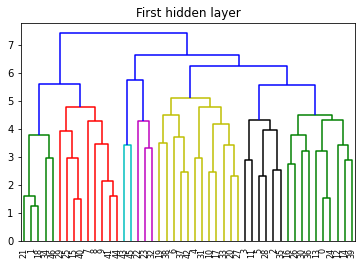

In [32]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

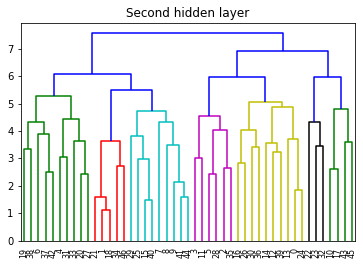

In [33]:
_plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

## Linear read-out

In [34]:
last_layer_size = dbn_emnist.rbm_layers[-1].W.shape[0]

class Perceptron(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(last_layer_size, 47) # changed to EMNIST Balanced number of classes 47

  def forward(self, x):
    return self.linear(x)

In [35]:
perceptron = Perceptron()

In [36]:
optimizer = torch.optim.SGD(perceptron.parameters(), lr=0.05)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 1000
print_every_n_epochs = 100 if epochs >= 1000 else 10

for epoch in range(epochs):
  optimizer.zero_grad()
  predictions = perceptron(hidden_repr_layer_2).squeeze()
  targets = emnist_targets_train.reshape(predictions.shape[0])
  loss = loss_fn(predictions, targets)
  loss.backward()
  optimizer.step()

  if epoch % print_every_n_epochs == 0:
    print("epoch : {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

epoch : 0/1000, loss = 3.858897
epoch : 100/1000, loss = 2.919368
epoch : 200/1000, loss = 2.385778
epoch : 300/1000, loss = 2.071493
epoch : 400/1000, loss = 1.874367
epoch : 500/1000, loss = 1.741445
epoch : 600/1000, loss = 1.645794
epoch : 700/1000, loss = 1.573222
epoch : 800/1000, loss = 1.515817
epoch : 900/1000, loss = 1.468907


Let's now build the representation for the test set we kept apart at the beginning:

In [37]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)

In [38]:
predictions_test = perceptron(hidden_repr_layer_2_test)

In [39]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == emnist_targets_test).sum() / len(emnist_targets_test)
  return accuracy.item()

In [40]:
_compute_accuracy(predictions_test, emnist_targets_test)

0.6315000057220459

# LAB 2

Train all data

In [41]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.0002,
                xavier_init=False,
                increase_to_cd_k=False,
                # use_gpu=False)
                use_gpu=True)

In [42]:
num_epochs = 40
batch_size = 125

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2751   |0.0383   |311.2659 |6.8444   |
|20    |1.2130   |0.0372   |292.2679 |5.6251   |
|30    |1.1940   |0.0353   |285.6981 |5.3934   |
|40    |1.1855   |0.0348   |282.0770 |5.4295   |


## Linear readouts

In [43]:
def _move_parameters_to_cpu(dbn_emnist):
  for layer in dbn_emnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [44]:
_move_parameters_to_cpu(dbn_emnist)

Let's first compute the hidden representations:

In [45]:
def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [46]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_train.data, 0)

In [47]:
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, nclasses)

  def forward(self, x):
    return self.linear(x)

### First hidden layer representations

Let's train the readout layer:

In [48]:
def _train(network, input, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    loss = loss_fn(predictions, emnist_train.targets)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [49]:
rbm_layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_1, epochs=1500)

epoch 0/1500, loss = 3.881119
epoch 100/1500, loss = 2.864200
epoch 200/1500, loss = 2.312044
epoch 300/1500, loss = 1.995068
epoch 400/1500, loss = 1.799303
epoch 500/1500, loss = 1.668462
epoch 600/1500, loss = 1.574749
epoch 700/1500, loss = 1.503800
epoch 800/1500, loss = 1.447722
epoch 900/1500, loss = 1.401897
epoch 1000/1500, loss = 1.363463
epoch 1100/1500, loss = 1.330557
epoch 1200/1500, loss = 1.301912
epoch 1300/1500, loss = 1.276635
epoch 1400/1500, loss = 1.254076


Let's test it on the hold-out dataset:

In [50]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_test.data, 0)

In [51]:
predictions_first_hidden = perceptron_first_hidden(hidden_repr_layer_1_test)

In [52]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [53]:
_compute_accuracy(predictions_first_hidden, emnist_test.targets)

0.6685638427734375

## Comparison with a feedforward model

Let's now train a simple feedforward neural network with the same structure as the RBM, i.e. with one hidden layer with `500` units.

We want to compare a network that is trained end-to-end to solve a classification task with a simple classifier that solves the same task using representations of input data learned in an *unsupervised* way.

In [54]:
# class Feedforward(torch.nn.Module):
#   def __init__(self, first_hidden_layer_size):
#     super().__init__()
#     self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
#     self.output = torch.nn.Linear(first_hidden_layer_size, nclasses)

#   def forward(self, input):
#     relu = torch.nn.ReLU()
#     first_hidden_repr = relu(self.first_hidden(input))
#     output = self.output(first_hidden_repr)
#     return output
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, nclasses)

  def forward(self, input):
    input = input.view((input.shape[0], -1))
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [55]:
ffnn = Feedforward(500)

We choose the number of epochs to match the training time of the RBM and the readout layer combined.

In [56]:
temp = emnist_train.data.size()[0]
_train(ffnn, emnist_train.data.reshape((temp, 784)), epochs=120)

epoch 0/120, loss = 3.857345
epoch 10/120, loss = 3.823199
epoch 20/120, loss = 3.789434
epoch 30/120, loss = 3.754468
epoch 40/120, loss = 3.717049
epoch 50/120, loss = 3.676270
epoch 60/120, loss = 3.631509
epoch 70/120, loss = 3.582449
epoch 80/120, loss = 3.528893
epoch 90/120, loss = 3.470743
epoch 100/120, loss = 3.408046
epoch 110/120, loss = 3.340972


In [57]:
predictions_ffnn = ffnn(emnist_test.data.reshape((round(temp/6), 784)))

In [58]:
_compute_accuracy(predictions_ffnn, emnist_test.targets)

0.38712766766548157

## Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the RBM are robust to noise.

In [59]:
def _inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(emnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return emnist_data - mask_tensor * emnist_data + mask_tensor * random_gaussian_tensor

Let's see what a noisy image looks like:

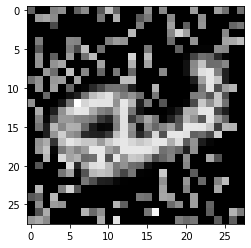

In [60]:
noise_level = 0.3
emnist_test_with_noise = _inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28), cmap="gray")

We will now compute the hidden representations for the noisy images using the RBM. Then, we will use the models that we trained on the representations without noise to classify the noisy ones.

In [61]:
temp2 = round(temp/6)
def _get_accuracy_values_at_noise_level(noise_level):
  emnist_test_with_noise = _inject_noise(emnist_test.data, noise_level)
  hidden_repr_layer_1_noisy = _get_kth_layer_repr(emnist_test_with_noise, 0)  # here we compute the representations
  predictions_first_hidden_noisy = perceptron_first_hidden(hidden_repr_layer_1_noisy)  # here we use the readout layer
  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((temp2, 784)))
  accuracy_first_hidden = _compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_ffnn = _compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)
  return accuracy_first_hidden, accuracy_ffnn

In [62]:
_get_accuracy_values_at_noise_level(0.2)

(0.49372339248657227, 0.3191489279270172)

Let's now get an overview of the robustness of the representations to different levels of noise:

In [63]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    accuracy_first_hidden, accuracy_ffnn = _get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(accuracy_first_hidden)
    accuracy_values_ffnn.append(accuracy_ffnn)

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "FFNN"])

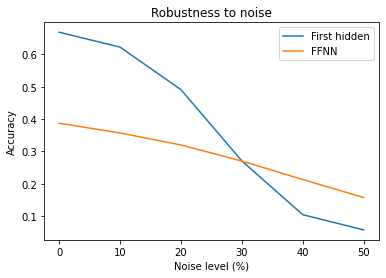

In [64]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plot_noise_robustness_curves(noise_levels)

# LAB 3

In [65]:
train_size = emnist_train.data.size()[0]
test_size = emnist_test.data.size()[0]

In [66]:
device = torch.device("cpu")

## Adversarial attacks

### Fast gradient sign method

Reference: https://jaketae.github.io/study/fgsm/

In general, with adversarial attacks we need to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the input, the model's parameters and the outputs: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure: 
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [67]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

### Adversarial samples

In [68]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, perceptron):
        super().__init__()
        self.readout = perceptron
        self.dbn_emnist = dbn_emnist

    def forward(self, image):
        x, __ = self.dbn_emnist.forward(image)
        x = self.readout.forward(x)
        return x

In [69]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, perceptron_first_hidden)

Let's see what an adversiarial sample looks like. Let't take one sample from the test set:

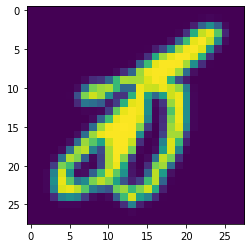

In [70]:
test_image = emnist_test.data[7].reshape(1, 28, 28)
__ = plt.imshow(test_image.reshape(28,28))

Now let's classify this image using a model, and modify the image to attack the network. To change the model we attack, you can modify the value of the `model` variable in the cell below (choosing between `ffnn` and `dbn_with_readout`).

In [71]:
ffnn = Feedforward(500)
# _train(ffnn, emnist_train.data, epochs=120)
attacked_model = ffnn

In [72]:
test_image.requires_grad = True
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this sample is {prediction}.")

test_image_label = emnist_test.targets[:1]
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, 0.2, image_grad)

The prediction of the model for this sample is 33.


Let's look at the adversarial sample:

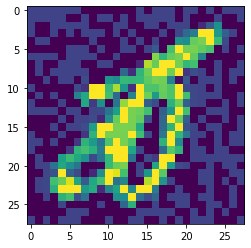

In [73]:
perturbed_image_np = perturbed_image.detach().numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [74]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 43.


### Resisting to adversarial attacks

Let's now compare the ability to resist to adversarial attacks of our two models: the feedforward network and the RBM.

We will also test the ability of the RBM to reduce the impact of the attack by performing one or more reconstruction steps, from the hidden representation to the visible units, and back to the hidden representation.

In [75]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(1, 28, 28)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data.detach().numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
      print("\nEpsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,
            correct, len(test_loader), final_acc))

    return final_acc

In [76]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/','balanced', train=False, download=False, transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
    ])),
    batch_size=1, shuffle=True)

Let's see how good the FFNN does:

In [77]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

100%|██████████| 18800/18800 [00:08<00:00, 2238.07it/s]


Epsilon: 0.1	Test Accuracy = 0 / 18800 = 0.0



Let's now compare compare the hidden representations of the RBM:

In [78]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

100%|██████████| 18800/18800 [00:18<00:00, 1004.21it/s]


Epsilon: 0.1	Test Accuracy = 5595 / 18800 = 0.2976063829787234



Now let's test the reconstruction power of the generative model:

  0%|          | 0/18800 [00:00<?, ?it/s]


Here's the original sample:



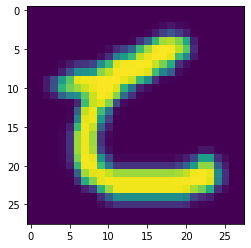


Here's a perturbed sample:



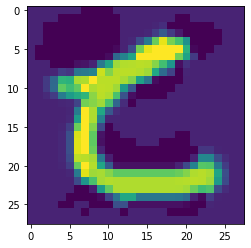


Here's what a 1-steps reconstructed sample looks like:



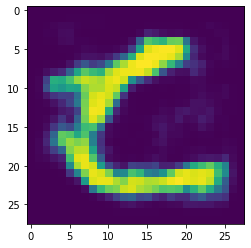

100%|██████████| 18800/18800 [00:24<00:00, 763.92it/s]


Epsilon: 0.1	Test Accuracy = 7390 / 18800 = 0.3930851063829787



In [79]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

### Effect of the parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [80]:
epsilon_values = [0, .05, .1, .15, .2, .25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [81]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_rbm_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_rbm_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)
accuracies_rbm_2 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)

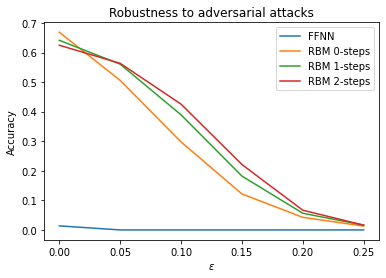

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), sharey=True)

__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_rbm_0)
__ = ax.plot(epsilon_values, accuracies_rbm_1)
__ = ax.plot(epsilon_values, accuracies_rbm_2)
__ = ax.set_xlabel("$\epsilon$")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks")
__ = ax.legend(["FFNN", "RBM 0-steps", "RBM 1-steps","RBM 2-steps"])